# Data augmentation

## Select the same number of samples per class

Also, mix the highest concentrations per class.

## Imports

In [10]:
import random
import re
import shutil
from argparse import Namespace
from glob import glob
from pathlib import Path
from typing import Tuple

import numpy as np
from PIL import Image
import torch
from torch.utils.data import Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm.auto import tqdm

from src.utils_Img2Img import print_grid

### Original dataset

In [2]:
args = Namespace(
    resolution=128,
    center_crop=False,
    random_flip=True,
    train_batch_size=16,
    dataloader_num_workers=8,
)

augmentations = transforms.Compose(
    [
        transforms.Resize(
            args.resolution, interpolation=transforms.InterpolationMode.BILINEAR
        ),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  # map to [-1, 1] for SiLU
    ]
)

data_root_path = "data/BBBC021_comp_conc_nice_phen_datalink_high_conc/train"

dataset = ImageFolder(
    root=data_root_path,
    transform=lambda x: augmentations(x.convert("RGB")),
    target_transform=lambda y: torch.tensor(y).long(),
)

In [3]:
unique, counts = np.unique(dataset.targets, return_counts=True)
print("Class names and indices:", [
      (cl, dataset.class_to_idx[cl]) for cl in dataset.classes])
print("Counts:", dict(zip(unique, counts)))

common_nb_samples = np.min(counts)
print("Common number of samples to select per class:", common_nb_samples)

Class names and indices: [('DMSO', 0), ('latrunculin_B_high_conc', 1)]
Counts: {0: 9765, 1: 1873}
Common number of samples to select per class: 1873


### Copy some samples to a "balanced" version

In [4]:
def get_full_names(selected_files: list[str], src_dir: Path) -> list[Tuple[Path, str]]:
    """Returns the (source, target) file path pairs,
    with possibly the intermediary directory name prefixed to it. eg:

    - DMSO (= src_dir)
        - file1
        - file2

    would give [(file1, file1), (file2, file2)], but:

    - latrunculin_B_high_conc (= src_dir)
        - latrunculin B 30
            - file1
            - file2
      - latrunculin B 10
            - file1

    would give [
        (latrunculin B 30/file1, latrunculin B 30_file1), 
        (latrunculin B 30/file2, latrunculin B 30_file2), 
        (latrunculin B 10/file1, latrunculin B 10_file1)
    ]                    ^                       ^     
                         |                       |
    (notice the         '/'          vs         '_')
    """
    selected_files_full_names = []

    for file in selected_files:
        # find the last part(s) (2 max)
        parts = Path(file).parts
        min_len = min(len(parts), len(src_dir.parts))
        idx = 0
        while idx < min_len and parts[idx] == src_dir.parts[idx]:
            idx += 1
        last_parts = parts[idx:]
        assert len(last_parts) <= 2
        # form the (Path, str) pair
        to_append = (Path(*last_parts), '_'.join(last_parts))
        selected_files_full_names.append(to_append)

    return selected_files_full_names

In [5]:
aug_data_root_path = "data/BBBC021_comp_conc_nice_phen_datalink_high_conc_balanced/train"

In [6]:
pbar = tqdm(total=common_nb_samples * len(dataset.classes))

for cl in dataset.classes:
    print(f"\n===========================> {cl}")
    # Set the source and destination directories
    src_dir = Path(data_root_path, cl)
    dst_dir = Path(aug_data_root_path, cl)
    print(f"Source directory:      {src_dir}")
    print(f"Destination directory: {dst_dir}")

    if dst_dir.exists():
        raise RuntimeError(f"{dst_dir} already exists!")
    print(f"Creating {dst_dir}")
    dst_dir.mkdir(parents=True, exist_ok=False)

    # Get a list of all PNG files in the source directory
    # A single class might have multiple subdirectories
    # so we need some glob magic
    pathname = src_dir.as_posix() + "/**/*.png"
    png_file_paths = list(glob(pathname, recursive=True))
    print(f"Found {len(png_file_paths)} PNG files")

    # Check if there are enough PNG files to select from
    if len(png_file_paths) < common_nb_samples:
        raise ValueError(f"Not enough PNG files in {src_dir} to select from.")

    # Select a random subset of PNG files
    selected_files = random.sample(png_file_paths, common_nb_samples)

    # Copy the selected files to the destination directory
    # first get their name (+ possibly intermediary class)
    selected_files_full_names = get_full_names(selected_files, src_dir)

    for srcfilename, trgtfilename in selected_files_full_names:
        src_path = Path(src_dir, srcfilename)
        dst_path = Path(dst_dir, trgtfilename)
        pbar.set_postfix_str(f"{src_path} -> {dst_path}")
        if dst_path.exists():
            raise RuntimeError(f"{dst_path} already exists!")
        shutil.copy(src_path, dst_path)
        pbar.update()

pbar.close()

  0%|          | 0/3746 [00:00<?, ?it/s]


===========================> DMSO
Source directory:      data/BBBC021_comp_conc_nice_phen_datalink_high_conc/train/DMSO
Destination directory: data/BBBC021_comp_conc_nice_phen_datalink_high_conc_balanced/train/DMSO
Creating data/BBBC021_comp_conc_nice_phen_datalink_high_conc_balanced/train/DMSO
Found 9765 PNG files

===========================> latrunculin_B_high_conc
Source directory:      data/BBBC021_comp_conc_nice_phen_datalink_high_conc/train/latrunculin_B_high_conc
Destination directory: data/BBBC021_comp_conc_nice_phen_datalink_high_conc_balanced/train/latrunculin_B_high_conc
Creating data/BBBC021_comp_conc_nice_phen_datalink_high_conc_balanced/train/latrunculin_B_high_conc
Found 1873 PNG files


## Perform data augmentation

The symmetry group of a square $\mathrm{Dih}_4$ is of order 8, so given the assumed semantic invariance of our 2D squared images (no up and down or right and left, no bottom and above), we can achieve up to 8x times data augmentation.

In [7]:
OPS = (
    "rot1",
    "rot2",
    "flip2rot2",
    "flip1rot2",
    "rot3",
    "flip2rot3",
    "flip1rot3",
)

In [8]:
def perform_data_aug_op(image: np.ndarray, op_code: str):
    """
    Performs the data augmentation operation given by op_code on the image.

    Arguments
    =========
    - image: array, shape (3, res, res)

    - op_code: str

    Returns
    =======
    - modified_image: array, same shape
    """

    assert op_code in OPS, "op_code not in OPS_LIST"

    image = image.copy()

    if op_code == "id":
        modified_image = image
    elif re.match(r"rot\d", op_code):
        res = re.match(r"rot\d", op_code).group()
        r = int(res[-1])
        modified_image = np.rot90(image, r, (1, 2))
    elif re.match(r"flip\drot\d", op_code):
        res = re.match(r"flip\drot\d", op_code).group()
        r, f = int(res[-1]), int(res[-5])
        modified_image = np.flip(np.rot90(image, r, (1, 2)), f)
    else:
        raise ValueError("No match!?")

    return modified_image

Check


===========================> DMSO
Directory: data/BBBC021_comp_conc_nice_phen_datalink_high_conc_balanced/train/DMSO
Found 1873 PNG files


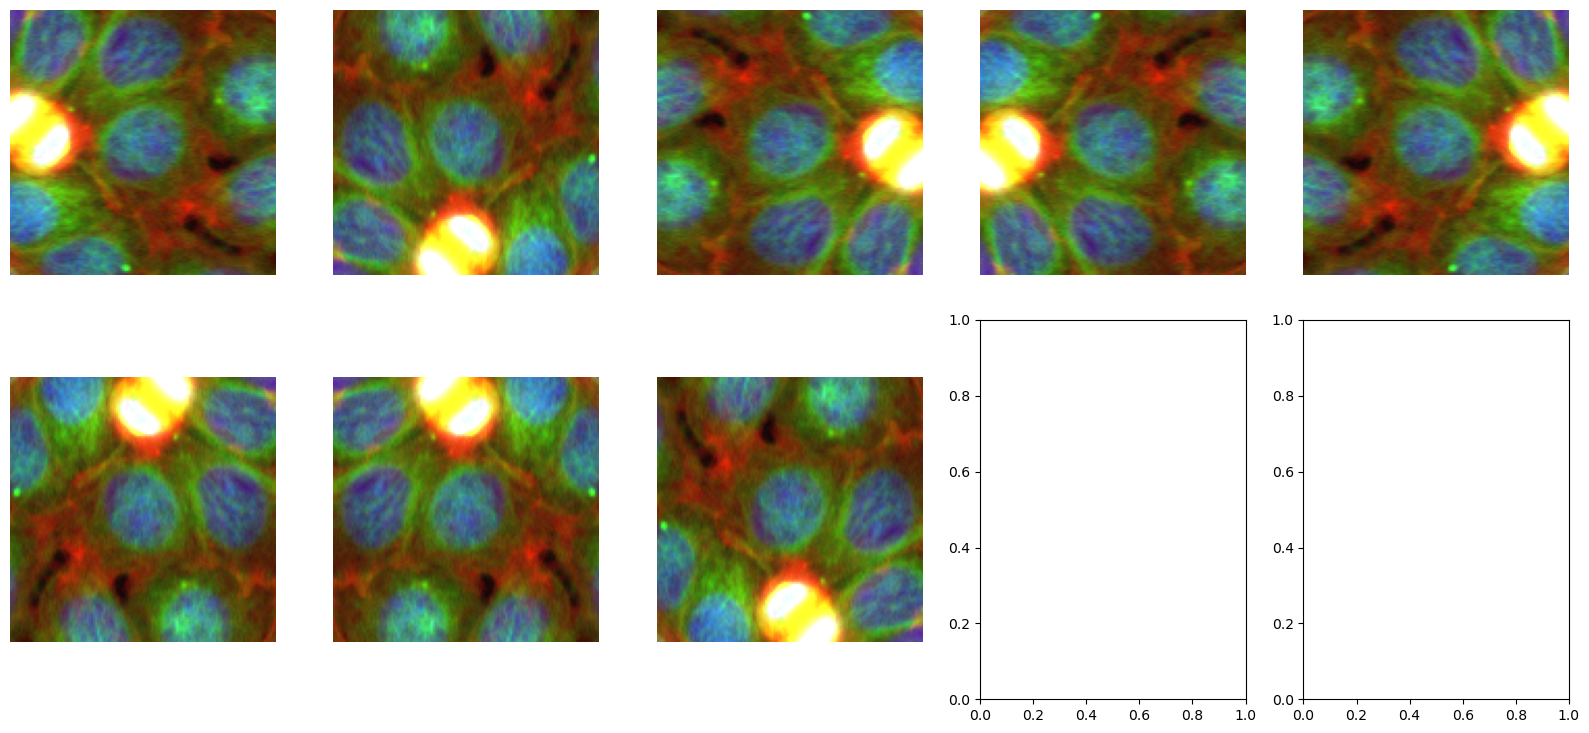


===========================> latrunculin_B_high_conc
Directory: data/BBBC021_comp_conc_nice_phen_datalink_high_conc_balanced/train/latrunculin_B_high_conc
Found 1873 PNG files


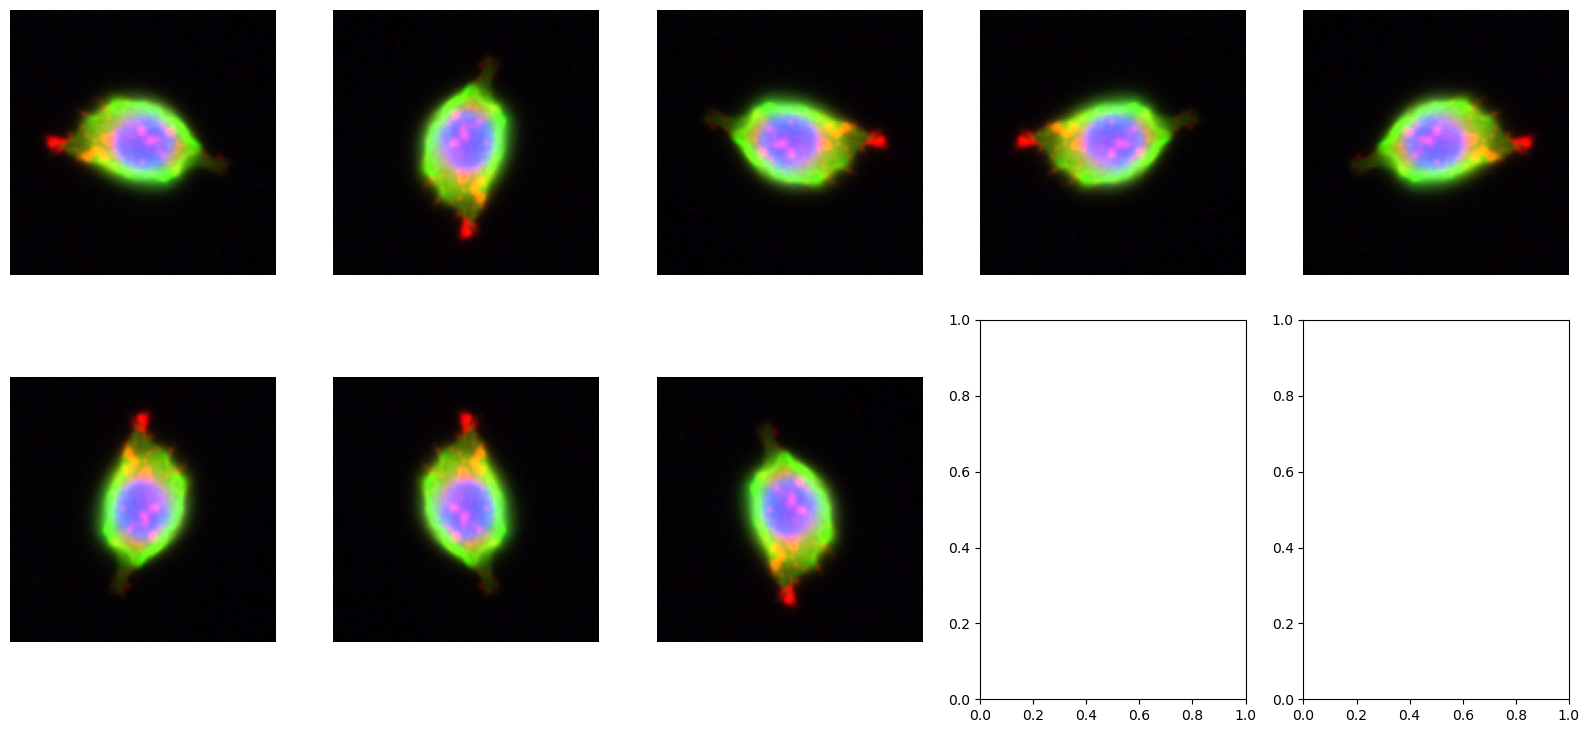

In [11]:
for cl in dataset.classes:
    img_list = []
    print(f"\n===========================> {cl}")
    # Set the source and destination directories
    dir = Path(aug_data_root_path, cl)
    print(f"Directory: {dir}")

    # Get a list of all PNG files in the directory
    png_file_paths = list(dir.glob('**/*.png'))
    assert len(png_file_paths) == common_nb_samples
    print(f"Found {len(png_file_paths)} PNG files")

    # Perform data aug
    for file in png_file_paths:
        image = np.asarray(Image.open(file))
        image = image.transpose(2, 0, 1)
        img_list.append(Image.open(file))
        for op_code in OPS:
            modified_image = perform_data_aug_op(image, op_code)
            # modified_image.save("file")
            img_list.append(Image.fromarray(modified_image.transpose(1, 2, 0)))
        break

    print_grid(img_list)

Save images

In [12]:
pbar = tqdm(total=common_nb_samples * len(dataset.classes) * len(OPS))

for cl in dataset.classes:
    print(f"\n===========================> {cl}")
    # Set the source and destination directories
    dir = Path(aug_data_root_path, cl)
    print(f"Directory: {dir}")

    # Get a list of all PNG files in the directory
    png_file_paths = list(dir.glob('**/*.png'))
    assert len(png_file_paths) == common_nb_samples
    print(f"Found {len(png_file_paths)} PNG files")

    # Perform data aug
    for file in png_file_paths:
        array = np.asarray(Image.open(file)).transpose(2, 0, 1)

        for op_code in OPS:
            modified_array = perform_data_aug_op(array, op_code)
            modif_filename = file.stem + "_" + op_code + ".png"
            modif_filepath = Path(file.parent, modif_filename)
            assert not modif_filepath.exists()
            img = Image.fromarray(modified_array.transpose(1, 2, 0))
            img.save(modif_filepath)
            pbar.update()

pbar.close()

  0%|          | 0/26222 [00:00<?, ?it/s]


===========================> DMSO
Directory: data/BBBC021_comp_conc_nice_phen_datalink_high_conc_balanced/train/DMSO
Found 1873 PNG files

===========================> latrunculin_B_high_conc
Directory: data/BBBC021_comp_conc_nice_phen_datalink_high_conc_balanced/train/latrunculin_B_high_conc
Found 1873 PNG files
